### Loading packages

In [1]:
#Loading packages
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import sys

### Making synthetic dataset

In [2]:
### SYNTHETIC DATSET ###
np.random.seed(6)

n_samples = 1000

# Category 1: Genetic factors
G1 = np.random.normal(0, 1, n_samples)
G2 = np.random.normal(0, 1, n_samples)
G3 = np.random.normal(0, 1, n_samples)


# Category 2: Environmental exposures (binary and continuous)
E1 = np.random.normal(0, 1, n_samples)              
E2 = np.random.binomial(n=1, p=0.5, size=n_samples) 

# Category 3: Nutritional
N1 = np.random.normal(0, 1, n_samples)            
N2 = np.random.normal(0, 1, n_samples) 

# Category 4: Metabolic
M1 = np.random.normal(0, 1, n_samples)
M2 = np.random.normal(0, 1, n_samples) 


In [3]:
# synthetic dataset

y = (   
    0.5 * G3 +
    0.7 * E2 +
    0.2 * N1 +
    0.3 * M1 +
    + 1.8 * G1 * E1 #interaction between 2 features
    + 1.8 * G2 * N2 * M2 # higher order interaction
)




In [4]:


# Clip target to simulate z-score range
#y = np.clip(y, -3, 3)

# Assemble into a DataFrame
synthetic_df = pd.DataFrame({
    'G1': G1,
    'G2': G2,
    'G3': G3,
    'E1': E1,
    'E2': E2,
    'N1': N1,
    'N2': N2,
    'M1': M1,
    'M2': M2,
    'y': y
})

# Preview
print(synthetic_df.head())

         G1        G2        G3        E1  E2        N1        N2        M1  \
0 -0.311784 -1.418699 -1.260993  0.132408   0  2.049664 -0.338455 -0.426517   
1  0.729004 -0.160942 -1.024372 -1.651252   1  1.050320 -0.894394  0.097983   
2  0.217821  0.213931 -0.182401 -1.499079   1  0.489765 -1.668413  2.362459   
3 -0.899092  1.281692 -1.209049  0.127766   0 -0.492195  1.919627  0.323312   
4 -2.486781 -2.382922 -1.086511  0.249325   0 -1.144469  0.575439 -0.101861   

         M2         y  
0 -0.549591 -0.897839  
1 -1.542525 -2.139181  
2  0.806702  0.309457  
3  0.130645 -0.234160  
4  0.217153 -2.454715  


In [5]:
import numpy as np

class PerfectWrapper:
    def __init__(self):
        # Define feature ordering if needed
        self.feature_names = ['G1', 'G2', 'G3', 'E1', 'E2', 'N1', 'N2', 'M1', 'M2']

    def predict(self, X):
        # If input is a DataFrame, convert to NumPy in correct order
        if hasattr(X, 'loc') or hasattr(X, 'iloc'):
            X = X[self.feature_names].values

        G1 = X[:, 0]
        G2 = X[:, 1]
        G3 = X[:, 2]
        E1 = X[:, 3]
        E2 = X[:, 4]
        N1 = X[:, 5]
        N2 = X[:, 6]
        M1 = X[:, 7]
        M2 = X[:, 8]

        y = (
            0.5 * G3 +
            0.7 * E2 +
            0.2 * N1 +
            0.3 * M1 +
            + 1.8 * G1 * E1 #interaction between 2 features
            + 1.8 * G2 * N2 * M2 # higher order interaction
        )
        return y


In [6]:
model = PerfectWrapper()
X = synthetic_df.drop(columns='y')
y_pred = model.predict(X)

print(np.allclose(y_pred, synthetic_df['y']))  # Should be True

import pickle

# Create and save the perfect wrapper
model = PerfectWrapper()

with open("perfect_model.pkl", "wb") as f:
    pickle.dump(model, f)


True


In [7]:
import json

feature_categories = {
    "Genetic": ["G1", "G2","G3"],
    "Environment": ["E1", "E2"],
    "Nutritional": ["N1", "N2"],
    "Metabolic": ["M1", "M2"]
}

with open("synthetic_feature_categories.json", "w") as f:
    json.dump(feature_categories, f, indent=2)

feature_categories = {
    "Actionable": ["E1", "E2", "N1", "N2", "M1", "M2"]
}

with open("synthetic_feature_categories_action.json", "w") as f:
    json.dump(feature_categories, f, indent=2)

In [8]:
X_train

NameError: name 'X_train' is not defined

### Linear and HGB model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
np.random.seed(6)
import pickle

# Split data and save training and testing sets (training set is required for COALA)
X = synthetic_df.drop(columns='y')
y = synthetic_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.to_csv(f"synthetic_train.csv")
X_test.to_csv(f"synthetic_test.csv")

# --- Linear Regression ---
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
y_pred_linreg = linreg_model.predict(X_test)

# --- XGBoost ---
'''
hgb_model = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, random_state=42)
hgb_model.fit(X_train, y_train)
y_pred_hgb = hgb_model.predict(X_test)
'''

# --- Evaluation ---
print("Linear Regression:")
print("R² Score:", r2_score(y_test, y_pred_linreg))
print("MSE:", mean_squared_error(y_test, y_pred_linreg))
'''
print("\HGBoost:")
print("R² Score:", r2_score(y_test, y_pred_hgb))
print("MSE:", mean_squared_error(y_test, y_pred_hgb))
'''
# --- Save models ---
with open(f'linear_model.pkl', 'wb') as f:
    pickle.dump(linreg_model, f)
'''
with open(f'hgboost_model.pkl', 'wb') as f:
    pickle.dump(hgb_model, f)
'''

Linear Regression:
R² Score: 0.04596385617105314
MSE: 10.455837836962509


"\nwith open(f'hgboost_model.pkl', 'wb') as f:\n    pickle.dump(hgb_model, f)\n"

In [10]:
coef = linreg_model.coef_        # slope(s)
intercept = linreg_model.intercept_  # y-intercept

# Print equation
terms = [f"{coef[i]:.5f} * x{i+1}" for i in range(len(coef))]
equation = " + ".join(terms)
print(f"y = {equation} + {intercept:.2f}")


y = -0.01759 * x1 + 0.31809 * x2 + 0.65178 * x3 + -0.00351 * x4 + 0.69259 * x5 + 0.31490 * x6 + -0.07100 * x7 + 0.29907 * x8 + -0.05872 * x9 + 0.01


In [11]:
np.array(X_train.max())

array([2.71437971, 2.76222988, 3.39054344, 2.73535115, 1.        ,
       3.46134263, 4.37811883, 2.95795777, 3.90629386])

### MLP

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import os
def find_binary_columns(df):
    binary_columns = []
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        if len(unique_values) == 2:
            binary_columns.append(column)
    return binary_columns
torch.manual_seed(6)

# 2. Preprocess (standard scale)
X = synthetic_df.drop(columns='y')
y = synthetic_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_test)
'''
X_val=X_test
indices_to_exclude = find_binary_columns(pd.DataFrame(pd.DataFrame(X_train)))
mask = np.array([i for i in range(X_train.shape[1]) if i not in indices_to_exclude])
X_train_transformed = scaler.fit_transform(X_train.values[:, mask], y_train.values)
X_train.values[:, mask] = X_train_transformed
#X_train = scaler.fit_transform(X_train, y_train)

#On X and y test
mask = np.array([i for i in range(X_val.shape[1]) if i not in indices_to_exclude])
X_val_transformed= scaler.transform(X_val.values[:, mask])
X_val.values[:, mask] = X_val_transformed
#X_val = scaler.transform(X_val)
'''
pd.DataFrame(X_train, columns=X.columns).to_csv("synthetic_train_scaled.csv", index=False)
pd.DataFrame(X_val, columns=X.columns).to_csv("synthetic_test_scaled.csv", index=False)

# 3. Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 4. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_val = X_train.to(device), X_val.to(device)
y_train, y_val = y_train.to(device), y_val.to(device)

# 5. Simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            #nn.Dropout(0.1),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)


mlp_model = SimpleMLP(X_train.shape[1]).to(device)

# 6. Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-4, weight_decay=1e-4)
#optimizer = torch.optim.SGD(mlp_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
num_epochs = 30000

# 7. Training loop
for epoch in range(num_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    predictions = mlp_model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        mlp_model.eval()
        with torch.no_grad():
            val_preds = mlp_model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            val_r2 = r2_score(y_val.cpu().numpy(), val_preds.cpu().numpy())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val R²: {val_r2:.4f}")

'''
with open(f"mlp_model.pkl", "wb") as f:
    pickle.dump(mlp_model, f)

model_dir = os.path.expanduser("~/MAP-CF/synthetic")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"mlp_model.pth")
torch.save(mlp_model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")
'''


Epoch 1000, Loss: 5.8783, Val Loss: 9.5287, Val R²: 0.1306
Epoch 2000, Loss: 1.6088, Val Loss: 4.8631, Val R²: 0.5563
Epoch 3000, Loss: 1.1078, Val Loss: 4.1525, Val R²: 0.6211
Epoch 4000, Loss: 0.7498, Val Loss: 3.5565, Val R²: 0.6755
Epoch 5000, Loss: 0.5097, Val Loss: 3.0281, Val R²: 0.7237
Epoch 6000, Loss: 0.3923, Val Loss: 2.7086, Val R²: 0.7529
Epoch 7000, Loss: 0.3233, Val Loss: 2.4623, Val R²: 0.7753
Epoch 8000, Loss: 0.2720, Val Loss: 2.2192, Val R²: 0.7975
Epoch 9000, Loss: 0.2264, Val Loss: 1.9962, Val R²: 0.8179
Epoch 10000, Loss: 0.1828, Val Loss: 1.7820, Val R²: 0.8374
Epoch 11000, Loss: 0.1424, Val Loss: 1.5777, Val R²: 0.8560
Epoch 12000, Loss: 0.1066, Val Loss: 1.3884, Val R²: 0.8733
Epoch 13000, Loss: 0.0764, Val Loss: 1.2182, Val R²: 0.8888
Epoch 14000, Loss: 0.0518, Val Loss: 1.0691, Val R²: 0.9025
Epoch 15000, Loss: 0.0327, Val Loss: 0.9412, Val R²: 0.9141
Epoch 16000, Loss: 0.0187, Val Loss: 0.8347, Val R²: 0.9238
Epoch 17000, Loss: 0.0094, Val Loss: 0.7498, Val 

'\nwith open(f"mlp_model.pkl", "wb") as f:\n    pickle.dump(mlp_model, f)\n\nmodel_dir = os.path.expanduser("~/MAP-CF/synthetic")\nos.makedirs(model_dir, exist_ok=True)\nmodel_path = os.path.join(model_dir, f"mlp_model.pth")\ntorch.save(mlp_model.state_dict(), model_path)\nprint(f"Model saved successfully at {model_path}")\n'

In [13]:
with open(f"mlp_model.pkl", "wb") as f:
    pickle.dump(mlp_model, f)

model_dir = os.path.expanduser("~/MAP-CF/synthetic")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"mlp_model.pth")
torch.save(mlp_model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")

Model saved successfully at /global/home/hpc5434/MAP-CF/synthetic/mlp_model.pth


In [14]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNRegressor

# Optional: Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1+2. Load your own synthetic data here
X = synthetic_df.drop(columns='y')
y = synthetic_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. (Optional) Scale features — TabPFN expects input features roughly scaled
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Initialize and fit the TabPFN Regressor
regressor = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu')
regressor.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)


/global/home/hpc5434/.local/lib/python3.11/site-packages/tabpfn/regressor.py:460: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Mean Squared Error (MSE): 4.793347138990627
R² Score: 0.5626341483271677


### Counterfactuals

In [ ]:
sys.path.append('/global/home/hpc5434/MAP-CF')
import cf_search.map as mapcf


### SHAP

  0%|          | 0/100 [00:00<?, ?it/s]

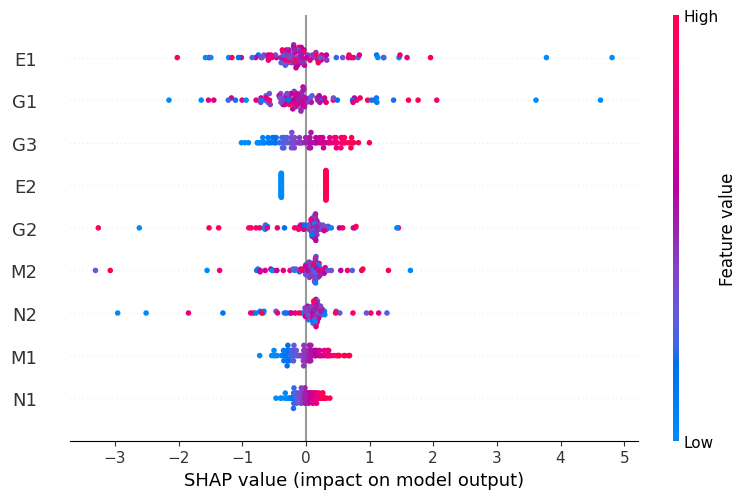

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Load your trained models (already trained)
# Assume you have:
# - linreg_model
# - rf_model
# - X_train_df (your feature matrix for training)
# - X_test_df (your test feature matrix)


# --- Linear Model SHAP ---
model = PerfectWrapper()
# Use TreeExplainer for random forest
#explainer = shap.TreeExplainer(model)
#explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train)
X_val=X_test
explainer = shap.KernelExplainer(model.predict, X_val)
#explainer = shap.GradientExplainer(model, X_val)


# Calculate SHAP values
shap_values = explainer.shap_values(X_val)

# Visualize SHAP summary plot for random forest
shap.summary_plot(shap_values, X_val)


In [ ]:
import shap

# 1. Move model to CPU and eval mode for SHAP
mlp_model.eval()
mlp_model.cpu()

# 2. Wrap the model in a function for SHAP
def model_fn(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        return mlp_model(x_tensor).numpy()

# 3. Prepare background and test data
X_train_np = X_train.cpu().numpy()
X_val_np = X_val.cpu().numpy()

# Use a small background sample (e.g., 100) to keep it fast
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]
test_samples = X_val_np[:10]  # Keep small to reduce compute time

# 4. Create KernelExplainer
explainer = shap.KernelExplainer(model_fn, background)

# 5. Compute interaction values (this is expensive!)
interaction_values = explainer.shap_interaction_values(test_samples)


AttributeError: 'KernelExplainer' object has no attribute 'shap_interaction_values'

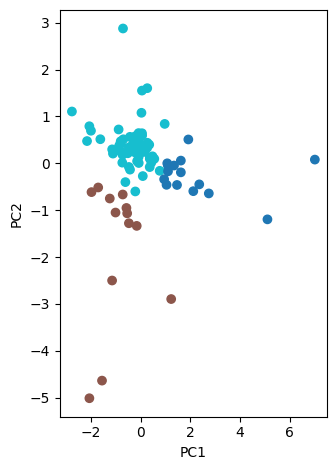

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Step 1: Convert SHAP values to a 2D array ---

# For random forest
shap_matrix = shap_values  # already a (n_samples, n_features) array from TreeExplainer

# --- Step 2: Cluster the SHAP vectors ---

n_clusters = 3  # you can choose 2, 3, 4 etc.

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(shap_matrix)

# --- Step 3: Visualize the clustering (optional simple plot) ---

# Use PCA or UMAP to reduce SHAP vectors to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_matrix)

# Plot Random Forest SHAP clusters
plt.subplot(1, 2, 2)
plt.scatter(shap_pca[:, 0], shap_pca[:, 1], c=clusters, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


#### SHAP clustering

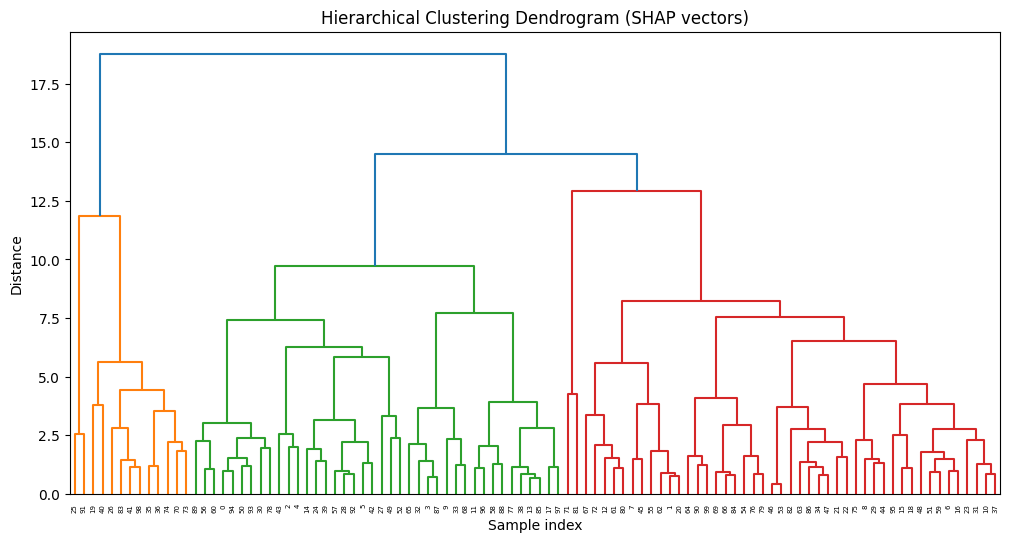

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

# Assume you already have:
# shap_matrix = SHAP values, shape (n_samples, n_features)
# From your earlier steps:
shap_matrix = shap_values   # (or shap_values_rf for random forest)

# If your shap_matrix is not standardized, standardize it (optional but often improves clustering)
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# --- Step 1: Perform hierarchical clustering ---
# 'ward' linkage + Euclidean distance
Z = linkage(shap_matrix_scaled, method='ward', metric='euclidean')

# --- Step 2: Plot dendrogram to visualize ---
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (SHAP vectors)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# --- Step 3: Cut dendrogram into clusters ---
n_clusters = 3
height = 10
#cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
cluster_labels = fcluster(Z, t=height, criterion='distance')

# Now:
# cluster_labels is a (n_samples,) array assigning each sample to a cluster 1, 2, 3


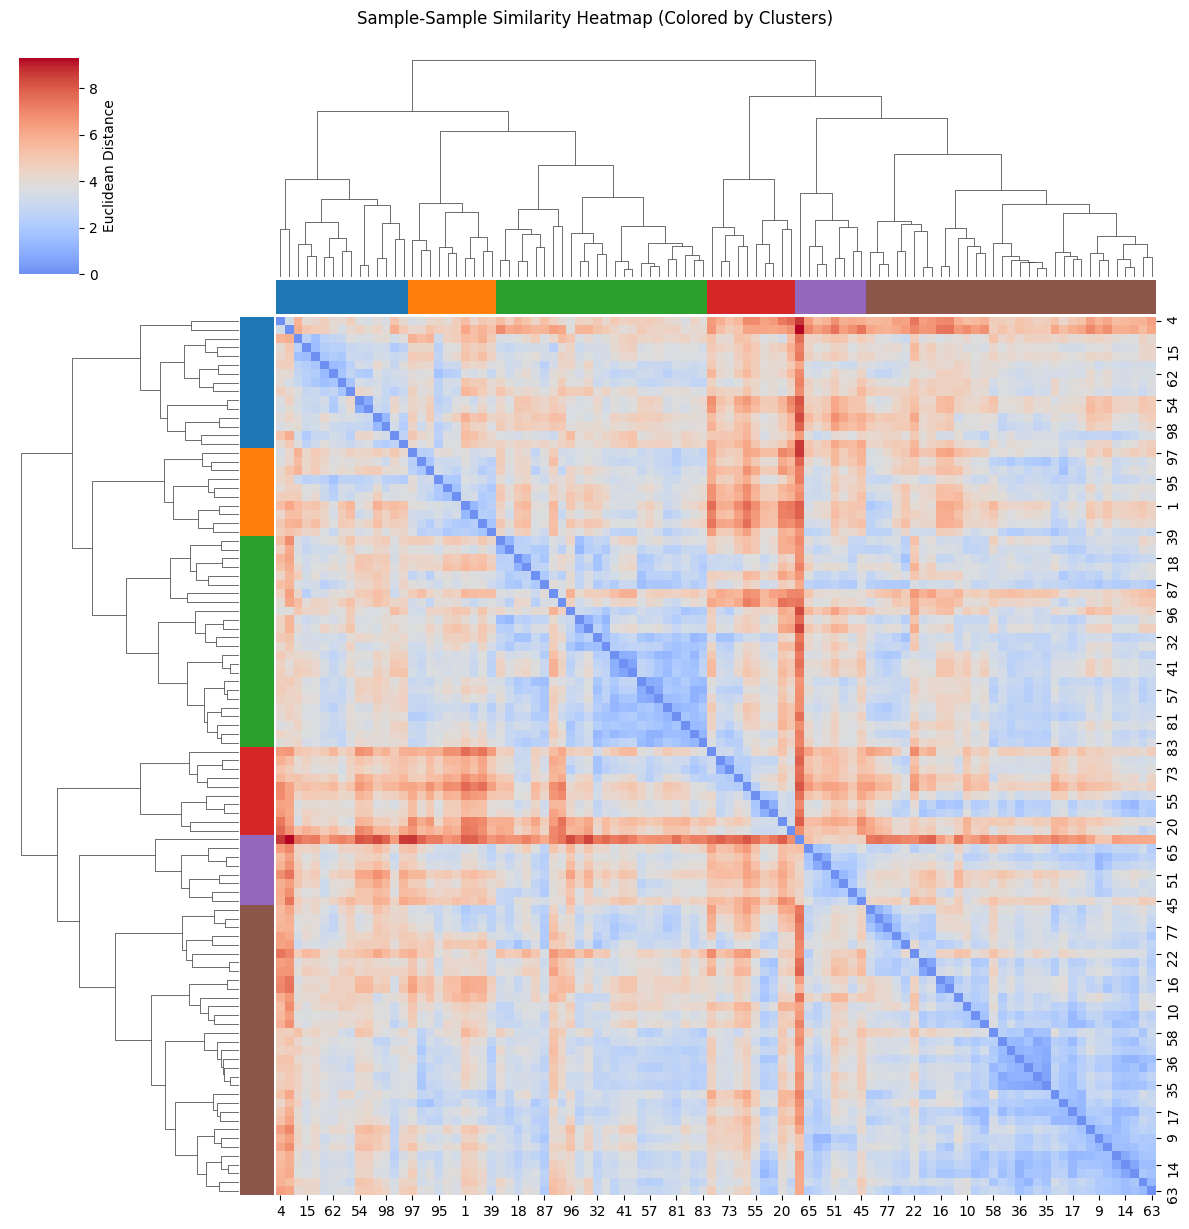

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler

# --- Assume you have your shap_matrix (n_samples, n_features) ---

# Step 1: Standardize SHAP values
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# Step 2: Compute pairwise distances
pairwise_distances = pdist(shap_matrix_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)

# Step 3: Hierarchical clustering
Z = linkage(pairwise_distances, method='ward')

# Step 4: Cut tree into clusters
n_clusters = 3
height = 10
#cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
cluster_labels = fcluster(Z, t=height, criterion='distance')
n_clusters = len(cluster_labels)
# Step 5: Assign colors to cluster labels
palette = sns.color_palette("tab10", n_clusters)
cluster_color_mapping = dict(zip(np.unique(cluster_labels), palette))
row_colors = pd.Series(cluster_labels).map(cluster_color_mapping).to_numpy()

# Step 6: Create clustermap
sns.clustermap(distance_matrix,
                   row_linkage=Z,
                   col_linkage=Z,
                   row_colors=row_colors,
                   col_colors=row_colors,
                   cmap='coolwarm',  # <- makes sure the HEATMAP (distance matrix) is coolwarm!
                   center=np.median(distance_matrix),  # Centering at median distance
                   figsize=(12, 12),
                   cbar_kws={"label": "Euclidean Distance"})

plt.suptitle('Sample-Sample Similarity Heatmap (Colored by Clusters)', y=1.02)
plt.show()


2025-06-12 01:54:12.412002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 01:54:12.426768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 01:54:12.431453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 01:54:12.444189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-12 01:54:21.548878: W tensorflow/compiler/tf2

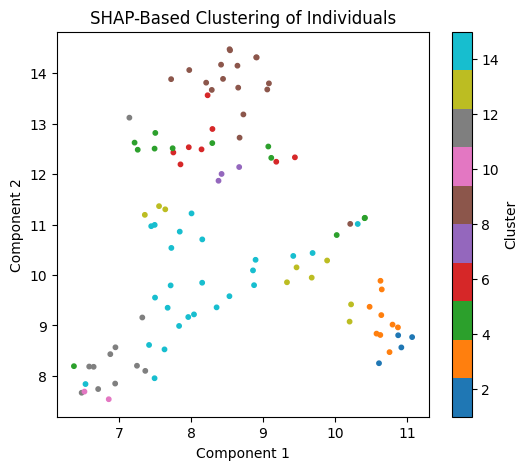

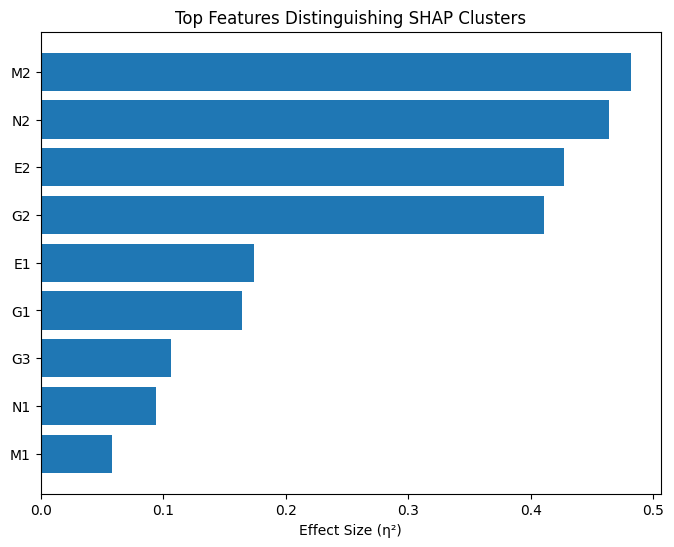

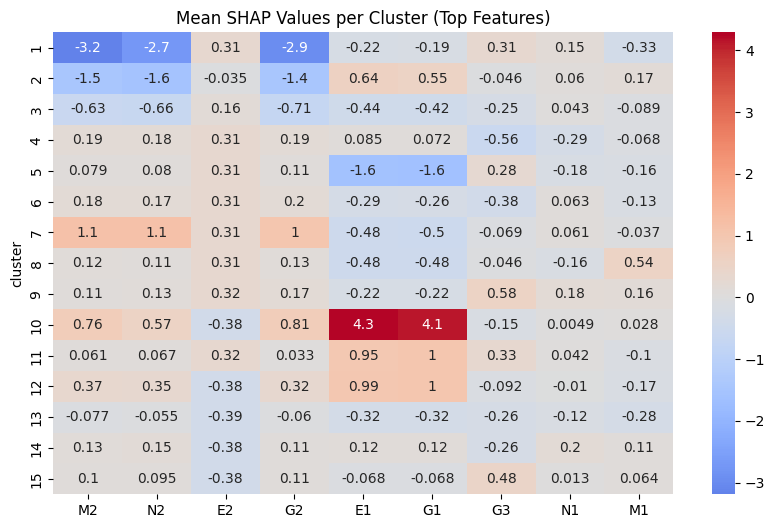

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.feature_selection import f_classif

# Assume:
# - shap_matrix (n_samples, n_features)
# - cluster_labels (n_samples,)

# --- Step 2: Project SHAP vectors into 2D for visualization ---

# Option 1: PCA
pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_matrix)

# Option 2 (better): UMAP
try:
    from umap import UMAP
    umap_model = UMAP(random_state=42)
    shap_umap = umap_model.fit_transform(shap_matrix)
except ImportError:
    shap_umap = shap_pca  # fallback to PCA if UMAP not available

# --- Step 3: Scatter plot colored by cluster ---

plt.figure(figsize=(6, 5))
plt.scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title('SHAP-Based Clustering of Individuals')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label="Cluster")
plt.show()

# --- Step 4: One-way ANOVA across clusters to find η² for each feature ---

# f_classif returns (F-values, p-values)
F_values, p_values = f_classif(shap_matrix, cluster_labels)

# η² (eta squared) = between-group variability / total variability
eta_squared = F_values / (F_values + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# --- Step 5: Rank features by η² and plot ---

# Sort by eta_squared descending
feature_names = X_test.columns.tolist()  # or however you have feature names
sorted_idx = np.argsort(-eta_squared)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2 = eta_squared[sorted_idx][:10]

# Barplot of top features
plt.figure(figsize=(8, 6))
plt.barh(top_features[::-1], top_eta2[::-1])
plt.xlabel('Effect Size (η²)')
plt.title('Top Features Distinguishing SHAP Clusters')
plt.show()

# --- Step 6: Average SHAP profiles per cluster ---

cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels

# Group by cluster
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

# Heatmap of average SHAP values
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(mean_shap_by_cluster.loc[:, top_features], annot=True, cmap='coolwarm', center=0)
plt.title('Mean SHAP Values per Cluster (Top Features)')
plt.show()


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


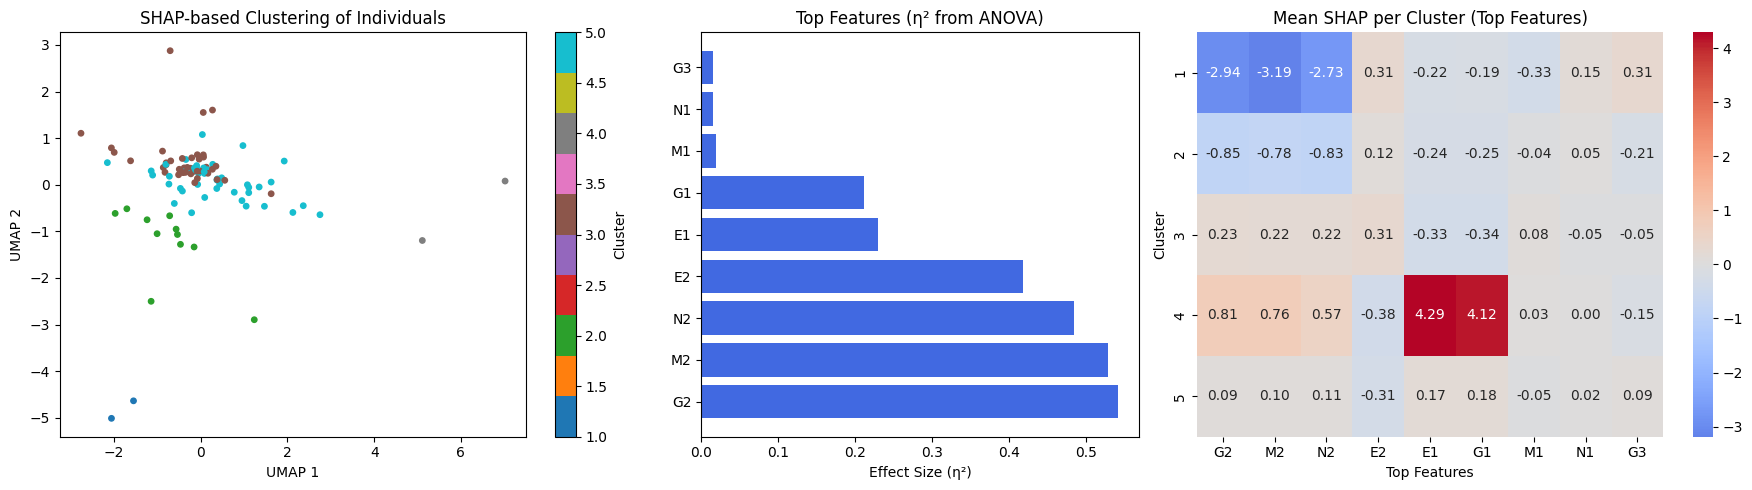

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
import seaborn as sns

# --- Assume you have already done ---
# - shap_matrix: (n_samples, n_features)
# - cluster_labels: array (n_samples,)
# - X_test.columns: feature names list

# If UMAP available
try:
    from umap import UMAP
    umap_model = UMAP(random_state=42)
    shap_umap = umap_model.fit_transform(shap_matrix)
except ImportError:
    print("UMAP not installed, falling back to PCA")
    pca = PCA(n_components=2)
    shap_umap = pca.fit_transform(shap_matrix)
pca = PCA(n_components=2)
shap_umap = pca.fit_transform(shap_matrix)

# --- Step 1: ANOVA (feature selection based on η²) ---
F_values, p_values = f_classif(shap_matrix, cluster_labels)
eta_squared = F_values / (F_values + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# Sort features by η² descending
feature_names = X_test.columns.tolist()
sorted_idx = np.argsort(-eta_squared)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2 = eta_squared[sorted_idx][:10]

# --- Step 2: Mean SHAP per cluster (for heatmap) ---
cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

# --- Step 3: Make Combined Figure ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1.5, 2]})

# --- Panel 1: UMAP scatter ---
sc = axs[0].scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=15)
axs[0].set_title('SHAP-based Clustering of Individuals')
axs[0].set_xlabel('UMAP 1')
axs[0].set_ylabel('UMAP 2')
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label('Cluster')

# --- Panel 2: Barplot of Top η² Features ---
axs[1].barh(top_features[::-1], top_eta2[::-1], color='royalblue')
axs[1].set_title('Top Features (η² from ANOVA)')
axs[1].set_xlabel('Effect Size (η²)')
axs[1].invert_yaxis()  # Highest on top

# --- Panel 3: Heatmap of Mean SHAP Values ---
sns.heatmap(mean_shap_by_cluster[top_features], cmap='coolwarm', center=0,
            annot=True, fmt=".2f", ax=axs[2])
axs[2].set_title('Mean SHAP per Cluster (Top Features)')
axs[2].set_xlabel('Top Features')
axs[2].set_ylabel('Cluster')

plt.tight_layout()
plt.show()


In [ ]:
### Simulating interventions
import copy

# --- Assume you have ---
# - X_test (your original input features, pandas DataFrame)
# - rf_model (or linreg_model)
# - cluster_labels

# Step 1: Choose which feature to intervene on
intervention_feature = 'E2'  # for example, one of your top features

# Step 2: Choose a new "healthier" value for the feature
# (Example: push M1 up to 1.5 if it’s important for improving outcomes)
new_value = 1

# Step 3: Make a copy of X_test for intervention
X_test_intervened = X_test.copy()

# Apply the intervention (set the feature to new_value)
X_test_intervened[intervention_feature] = new_value

# Step 4: Predict risk before and after intervention
# Predict with original data
y_pred_original = rf_model.predict(X_test)

# Predict with intervened data
y_pred_intervened = rf_model.predict(X_test_intervened)

# Step 5: Calculate risk reduction per sample
risk_reduction = y_pred_original - y_pred_intervened

# Step 6: Aggregate risk reduction by cluster
result_df = pd.DataFrame({
    'cluster': cluster_labels,
    'risk_reduction': risk_reduction
})

cluster_risk_reduction = result_df.groupby('cluster')['risk_reduction'].mean()

# Step 7: Plot
plt.figure(figsize=(8,5))
cluster_risk_reduction.plot(kind='bar', color='forestgreen')
plt.title(f'Average Risk Reduction per Cluster after {intervention_feature} Intervention')
plt.xlabel('Cluster')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='black', linestyle='--')
plt.show()


NameError: name 'rf_model' is not defined

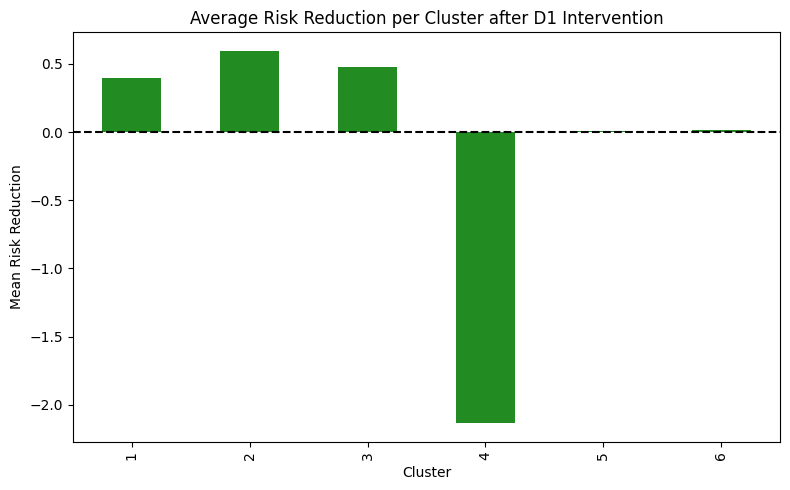

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Assumptions ---
# model: your loaded SimpleMLP model (on CPU or GPU)
# X_test: a pandas DataFrame (already scaled!)
# cluster_labels: 1D array-like of cluster assignments (same length as X_test)
# intervention_feature: string, one column in X_test
# new_value: float, the healthier target value

# Step 1: Choose the feature and value
intervention_feature = 'D1'
new_value = 1.6

# Step 2: Apply intervention
X_test_intervened = X_test.copy()
X_test_intervened[intervention_feature] = new_value

# Step 3: Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor_original = torch.tensor(X_test.values, dtype=torch.float32).to(device)
X_tensor_intervened = torch.tensor(X_test_intervened.values, dtype=torch.float32).to(device)

# Step 4: Predict using the model
model.eval()
with torch.no_grad():
    y_pred_original = model(X_tensor_original).cpu().numpy().flatten()
    y_pred_intervened = model(X_tensor_intervened).cpu().numpy().flatten()

# Step 5: Calculate risk reduction
risk_reduction = y_pred_original - y_pred_intervened

# Step 6: Aggregate by cluster
result_df = pd.DataFrame({
    'cluster': cluster_labels,
    'risk_reduction': risk_reduction
})
cluster_risk_reduction = result_df.groupby('cluster')['risk_reduction'].mean()

# Step 7: Plot
plt.figure(figsize=(8, 5))
cluster_risk_reduction.plot(kind='bar', color='forestgreen')
plt.title(f'Average Risk Reduction per Cluster after {intervention_feature} Intervention')
plt.xlabel('Cluster')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


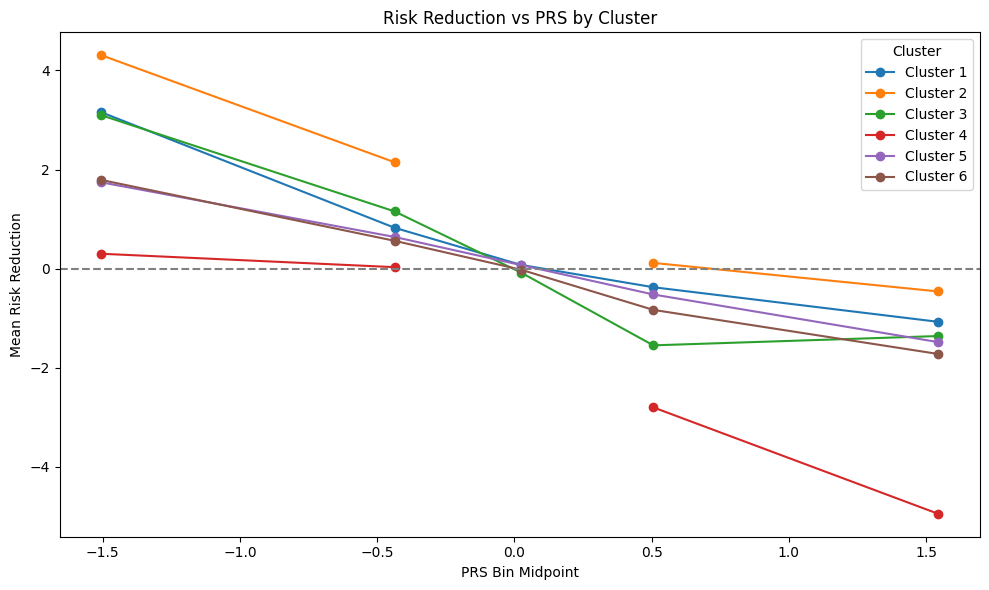

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate risk reduction (from previous code)
risk_reduction = y_pred_original - y_pred_intervened

# Step 2: Create a results DataFrame
result_df = X_test.copy()
result_df['cluster'] = cluster_labels
result_df['risk_reduction'] = risk_reduction
result_df['PRS'] = X_test['PRS']  # replace with your actual PRS column name

# Step 3: Bin PRS into quantiles or fixed-width bins
num_bins = 5
result_df['PRS_bin'] = pd.qcut(result_df['PRS'], q=num_bins, duplicates='drop')

# Step 4: Group by PRS_bin and cluster, then take mean
grouped = result_df.groupby(['PRS_bin', 'cluster'])['risk_reduction'].mean().reset_index()

# Convert PRS_bin to string midpoint for plotting (or keep as categorical for clean tick labels)
grouped['PRS_mid'] = grouped['PRS_bin'].apply(lambda b: b.mid)

# Step 5: Pivot for plotting
plot_df = grouped.pivot(index='PRS_mid', columns='cluster', values='risk_reduction')

# Step 6: Plot each cluster as a line
plt.figure(figsize=(10, 6))
for cluster in plot_df.columns:
    plt.plot(plot_df.index, plot_df[cluster], label=f'Cluster {cluster}', marker='o')

plt.title('Risk Reduction vs PRS by Cluster')
plt.xlabel('PRS Bin Midpoint')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


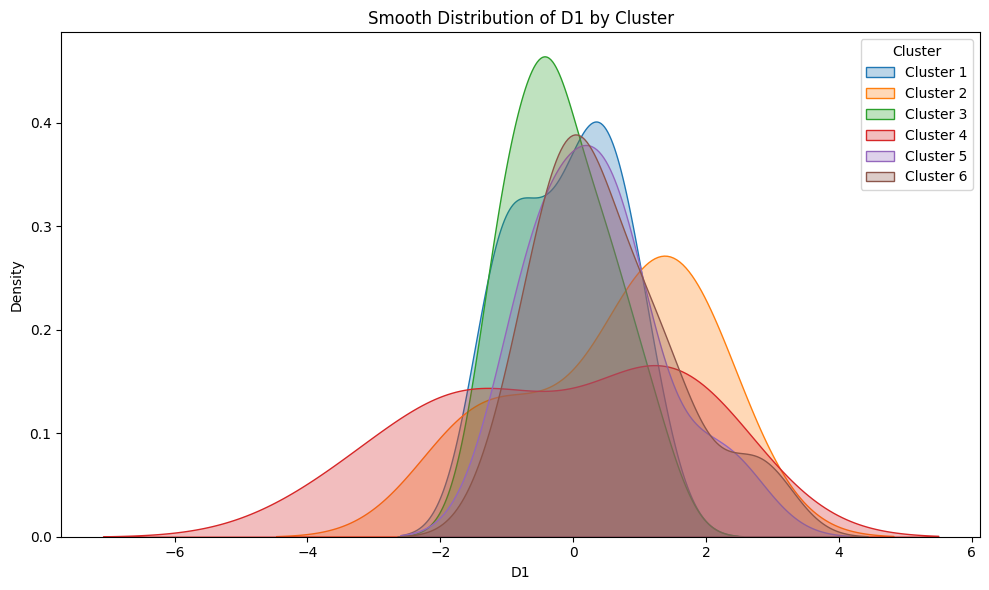

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare DataFrame ---
plot_df = X_test.copy()
plot_df['cluster'] = cluster_labels
plot_df['D1'] = X_test['D1']  # ensure this is the correct column

# --- Plot KDE for each cluster ---
plt.figure(figsize=(10, 6))
for cluster in sorted(plot_df['cluster'].unique()):
    subset = plot_df[plot_df['cluster'] == cluster]
    sns.kdeplot(subset['D1'], label=f'Cluster {cluster}', fill=True, alpha=0.3)

plt.title('Smooth Distribution of D1 by Cluster')
plt.xlabel('D1')
plt.ylabel('Density')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


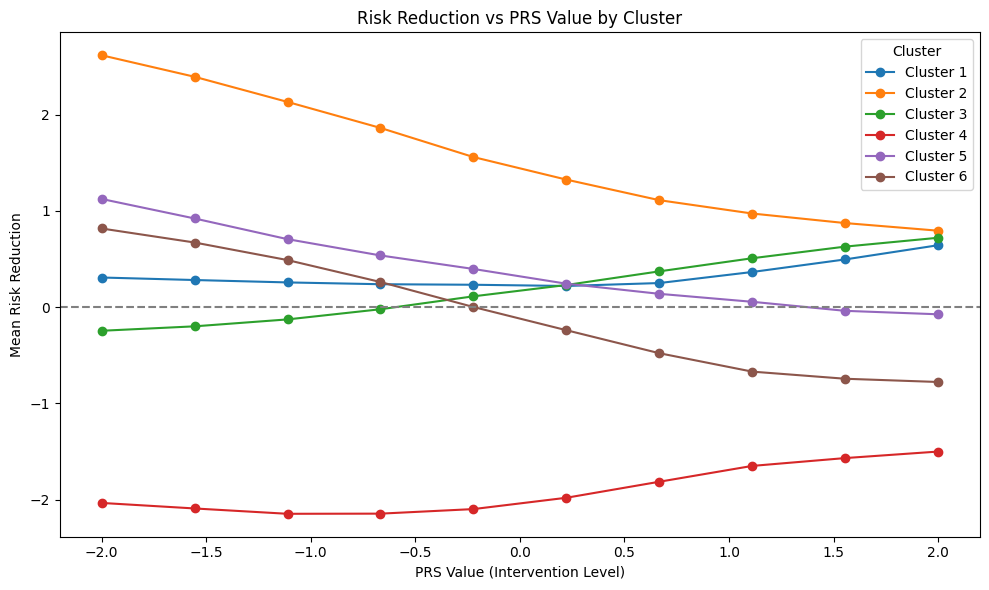

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Inputs ---
intervention_feature = 'PRS'
intervention_range = np.linspace(-2, 2.0, 10)  # range of D1 values to simulate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Container for results
results = []

# Loop through each intervention value
for val in intervention_range:
    # Apply intervention
    X_intervened = X_test.copy()
    X_intervened[intervention_feature] = val

    # Predict with original and intervened values
    X_tensor_original = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    X_tensor_intervened = torch.tensor(X_intervened.values, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_original = model(X_tensor_original).cpu().numpy().flatten()
        y_pred_intervened = model(X_tensor_intervened).cpu().numpy().flatten()

    # Compute risk reduction
    risk_reduction = y_pred_original - y_pred_intervened

    # Record results with cluster
    df = pd.DataFrame({
        'intervention_value': val,
        'cluster': cluster_labels,
        'risk_reduction': risk_reduction
    })

    results.append(df)

# Combine all
results_df = pd.concat(results)

# Group by intervention value + cluster
mean_reduction = results_df.groupby(['intervention_value', 'cluster'])['risk_reduction'].mean().reset_index()

# Pivot for plotting
plot_df = mean_reduction.pivot(index='intervention_value', columns='cluster', values='risk_reduction')

# --- Plot ---
plt.figure(figsize=(10, 6))
for cluster in plot_df.columns:
    plt.plot(plot_df.index, plot_df[cluster], label=f'Cluster {cluster}', marker='o')

plt.title(f'Risk Reduction vs {intervention_feature} Value by Cluster')
plt.xlabel(f'{intervention_feature} Value (Intervention Level)')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
